In [1]:
import os
os.environ["PATH"] += ":/usr/local/texlive/2024/bin/universal-darwin"

import numpy as np
import matplotlib.pylab as plt

from helpers import save_dict,load_dict

from sklearn.linear_model import LinearRegression


In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 15,
    "font.family": "Helvetica"

})

column_width = 3.75
square_fig_size=(2*column_width,3/2*column_width)


# Helper Functions

In [3]:
def get_intercept_error(X, Y, slope):
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    intercept_ols = mean_y - slope * mean_x
    intercept_error_ols = np.std(Y - (slope * X + intercept_ols))
    return intercept_error_ols


In [4]:
Ls = np.arange(6,31,6)
all_scales = [0.25,0.5,1.,2.,4.0]
scales = [1.,2.,4.,8.]
rates = [0.475,0.25,0.158]
Ts = [0.25,1.00]
mss = ['Square', 'Triangular']

rate_markers={0.25:'H',0.475:'^'}
rate_lines={0.25:'--',0.475:'-'}
T_alphas={'0.25':0.4,'1.00':0.9}

colorscale_sq = plt.get_cmap('viridis')
colorscale_tri = plt.get_cmap('plasma')
shades = np.linspace(0.,0.9,len(all_scales)+1)[::-1][:-1]
colors_sq = colorscale_sq(shades)
colors_tri = colorscale_tri(shades)
scale_shades = {'Square':{1.0:colors_sq[2],2.0:colors_sq[3],4.0:colors_sq[4]},'Triangular':{1.0:colors_tri[2],2.0:colors_tri[3],4.0:colors_tri[4]}}

# Load Data

PLEASE NOTE: final_energies_data.pkl is too large to host on git. If you are interested in reproducing this analysis, please reach out to me at msmoss@uwaterloo.ca and I can share the necessary file.

In [5]:
data = load_dict('./plotting_data/final_energies_data.pkl')

# Get zero variance energies

In [6]:
zero_var_energy = {}

ms_="Triangular"
bc_="periodic"
T_ = "{:.2f}".format(1.00)

if bc_=='open':
    which_scales=[2.0,4.0]
    which_rates = rates
else:
    which_scales=[1.0,2.0,4.0]
    which_rates = [0.158,0.25,0.475]
    # which_scales=scales

print('-'*50)
print(f'{bc_}')
print('-'*50)

zero_var_energy[bc_] = {}
title = bc_
data_ = data[f"{ms_}MS,{bc_}BC"]

for L in Ls:    
    zero_var_energy[bc_][L] = {}

    ## Gather all the data points for a given L
    toplot_x = []
    toplot_y = []
    toplot_yerr = []
    for rate_i, rate in enumerate(which_rates):
        for scale_i, scale in enumerate(which_scales):
            N = L**2
            if (f'L={L}' in data_[f'scale={scale},rate={rate},T={T_}'].keys()):
                if 'final energy' in data_[f'scale={scale},rate={rate},T={T_}'][f'L={L}'].keys():
                    en = np.real(data_[f'scale={scale},rate={rate},T={T_}'][f'L={L}']['final energy'])
                    var = np.real(data_[f'scale={scale},rate={rate},T={T_}'][f'L={L}']['final var'])
                    err = np.real(data_[f'scale={scale},rate={rate},T={T_}'][f'L={L}']['final std error'])

                    if ((scale>=2) & (rate<0.475)) or ((scale==1) & (rate==0.158)):
                        toplot_x.append(var)
                        toplot_y.append(en)   
                        toplot_yerr.append(err)   

    zero_var_energy[bc_][L]['energies'] = np.array(toplot_y)
    zero_var_energy[bc_][L]['variances'] = np.array(toplot_x)
    zero_var_energy[bc_][L]['errors'] = np.array(toplot_yerr)

    ## Perform a linear fit through x=var(E) y=E 
    if len(toplot_x) > 1:
        reg_x = np.array(toplot_x)[:,np.newaxis]
        reg_y = toplot_y
        reg = LinearRegression().fit(reg_x, reg_y)  
        score = reg.score(reg_x, reg_y)
        err = get_intercept_error(reg_x, reg_y, reg.coef_) # assumes homoskedasticity

        zero_var_energy[bc_][L]['slope'] = reg.coef_
        zero_var_energy[bc_][L]['y-int'] = reg.intercept_
        zero_var_energy[bc_][L]['y-int err'] = err
        zero_var_energy[bc_][L]['R^2'] = score
        zero_var_energy[bc_][L]['residuals'] = reg_y - (reg.coef_*toplot_x+reg.intercept_)
        zero_var_energy[bc_][L]['predicted ys'] = reg.coef_*toplot_x+reg.intercept_

        min_energy = min(zero_var_energy[bc_][L]['energies'])
        min_energy_i = np.where(zero_var_energy[bc_][L]['energies']==min_energy)
        print(f"Min energy L={L}: {min_energy} +/- {zero_var_energy[bc_][L]['errors'][min_energy_i]}")


--------------------------------------------------
periodic
--------------------------------------------------
Min energy L=6: -0.5562074449327257 +/- [0.00019305 0.00019305]
Min energy L=12: -0.5493287510342069 +/- [9.79304702e-05]
Min energy L=18: -0.5486121942967545 +/- [6.83154953e-05]
Min energy L=24: -0.5481048689948188 +/- [5.59467328e-05]
Min energy L=30: -0.5479338243272569 +/- [4.46448681e-05]


0.9142128466523626


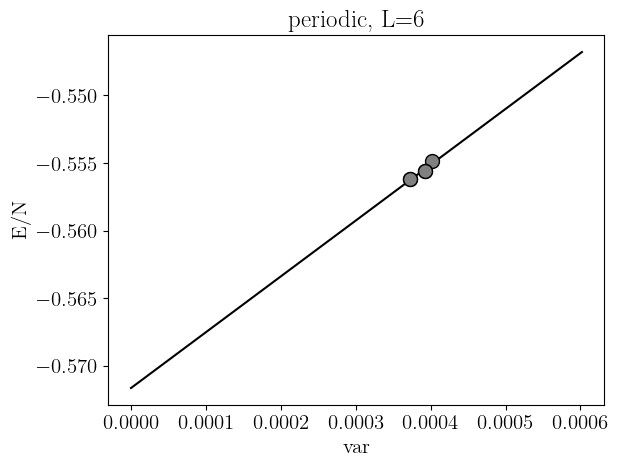

0.9355364750652603


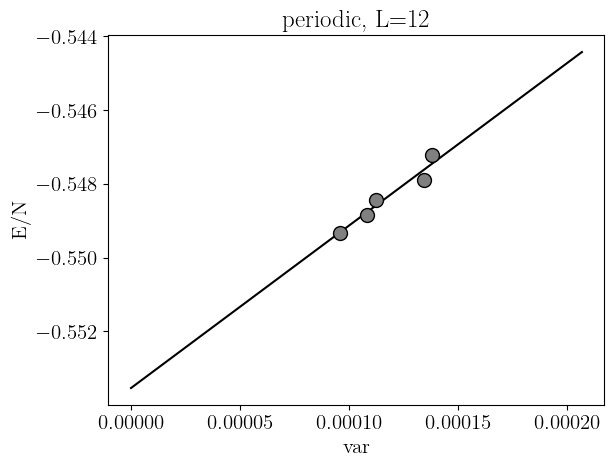

0.9548086615802193


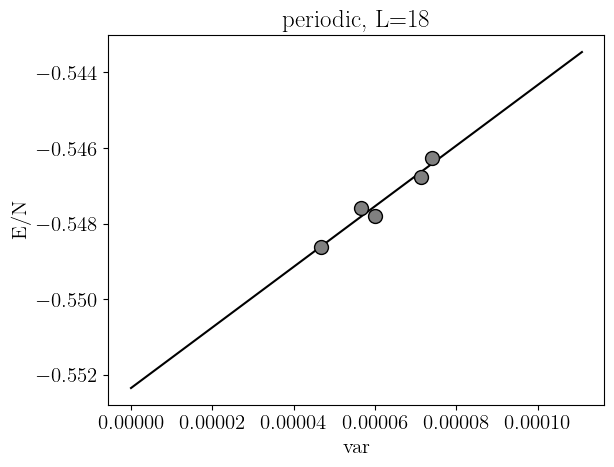

0.9703231114834557


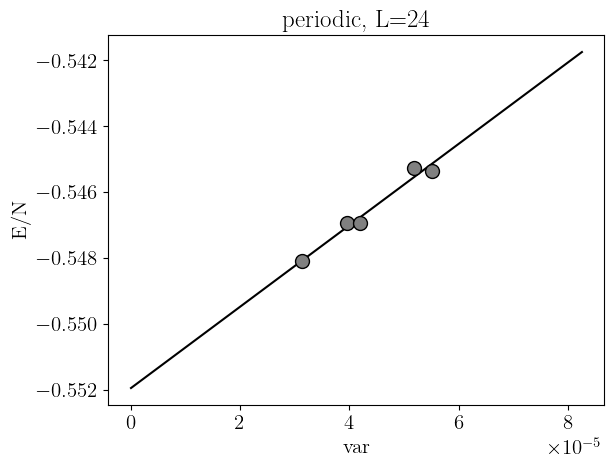

0.9730432094033244


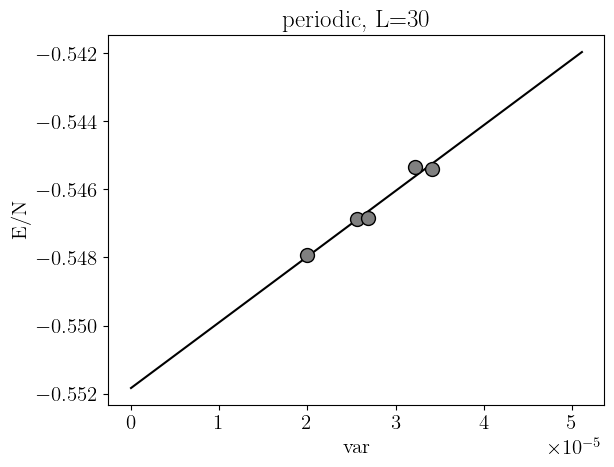

In [7]:
bc = 'periodic'

for L in Ls:
    if 'slope' in zero_var_energy[bc][L].keys():
        x = zero_var_energy[bc][L]['variances']
        y = zero_var_energy[bc][L]['energies']
        slope = zero_var_energy[bc][L]['slope']
        y_int = zero_var_energy[bc][L]['y-int']
        y_int_err = zero_var_energy[bc][L]['y-int err']
        print(zero_var_energy[bc][L]['R^2'])

        x_mesh = np.arange(0, 1.5*max(x), 10**-10)
        plt.errorbar(x, y,yerr=np.sqrt(x)/10000,
                    marker='o',fmt='o',ms=10,capsize=0,
                    mfc='grey',mec='k',c='k')                

        plt.plot(x_mesh,slope*x_mesh+y_int,color='k')

        plt.ylabel('E/N')
        plt.xlabel('var')
        plt.title(bc+f", L={L}")
        plt.show()

# Bootstrap

In [8]:
Nb = 1000

np.random.seed(100)

for bc in ['periodic']:
    print('-'*50)
    print(f'{bc}')
    print('-'*50)
    for L in Ls:

        if 'residuals' in zero_var_energy[bc][L].keys():
            xs = np.reshape(np.tile(zero_var_energy[bc][L]['variances'], Nb),(Nb,-1))
            residuals = np.array(zero_var_energy[bc][L]['residuals'])
            predicted_ys = np.array(zero_var_energy[bc][L]['predicted ys'])
            gaussian_vars = np.random.normal(loc=0.0,scale=1.0,size=(Nb,len(predicted_ys)))

            # Get resampled y values
            resampled_ys = predicted_ys + residuals * gaussian_vars

            # Perform linear fits through resampled data
            intercepts = []
            for b in range(Nb):
                reg_x_b = xs[b,:][:,np.newaxis]
                reg_y_b = resampled_ys[b,:]
                reg_b = LinearRegression().fit(reg_x_b, reg_y_b)     
                intercepts.append(reg_b.intercept_)

            intercepts = np.array(intercepts)

            # Get bootstrapped estimates for y-intercept and error
            zero_var_energy[bc][L]['y-int bootstrapped'] = np.mean(intercepts)
            zero_var_energy[bc][L]['y-int err bootstrapped'] = np.std(intercepts)/np.sqrt(Nb)

            print(f"bootstrapped y-int L={L}: {zero_var_energy[bc][L]['y-int bootstrapped']} +/ {zero_var_energy[bc][L]['y-int err bootstrapped']}")


--------------------------------------------------
periodic
--------------------------------------------------
bootstrapped y-int L=6: -0.5715929036623673 +/ 6.776045019430916e-05
bootstrapped y-int L=12: -0.5535126981063725 +/ 1.8034268347867782e-05
bootstrapped y-int L=18: -0.5523641109774937 +/ 1.020802290731506e-05
bootstrapped y-int L=24: -0.5519476216427209 +/ 1.0308198200506079e-05
bootstrapped y-int L=30: -0.5518338180550414 +/ 9.624002280588048e-06


In [9]:
zero_var_energy_final = {}
for bc in ['periodic']:
    zero_var_energy_final[bc] = {}
    zero_var_energy_final[bc]['Ls'] = []
    zero_var_energy_final[bc]['energies'] = []
    zero_var_energy_final[bc]['energy errors'] = []
    zero_var_energy_final[bc]['energies bootstrapped'] = []
    zero_var_energy_final[bc]['energy errors bootstrapped'] = []
    for L in Ls:
        if 'y-int' in zero_var_energy[bc][L].keys():
            zero_var_energy_final[bc]['Ls'].append(L)
            zero_var_energy_final[bc]['energies'].append(zero_var_energy[bc][L]['y-int'])
            zero_var_energy_final[bc]['energy errors'].append(zero_var_energy[bc][L]['y-int err'])
            zero_var_energy_final[bc]['energies bootstrapped'].append(zero_var_energy[bc][L]['y-int bootstrapped'])
            zero_var_energy_final[bc]['energy errors bootstrapped'].append(zero_var_energy[bc][L]['y-int err bootstrapped'])


In [10]:
final_data_path = './plotting_data/'
zero_var_energies_save_filename = final_data_path + 'zero_var_energies.pkl'
save_dict(zero_var_energy_final,zero_var_energies_save_filename)